# Notebook to test and illustrate FAST algorithm

In [1]:
%load_ext autoreload
%autoreload 2

### Tests on single image

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

import fast
import opticalFlow

### global params

In [3]:
TRAIN_FRAMES_FOR_KP_DETECTION = 10

START_IDX = 60
if START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION <= 0:
    START_IDX = TRAIN_FRAMES_FOR_KP_DETECTION + 1
END_IDX = 70
nb_keypoints = 50

#result_gif = 'imgs/person_dog_opticalFlow_opencv.gif'
result_gif = 'imgs/person_dog_opticalFlow_reimpl.gif'
skip = 1

### cv2 params

In [4]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = nb_keypoints,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take first frame and find corners in it
cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

### added params

In [5]:
START_IDX_KP = START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION
END_IDX_KP = START_IDX - 1

cols = 4
rows = 3

print(f"Train kp from {START_IDX_KP} to {END_IDX_KP}")

Train kp from 50 to 59


### Get KP

Number of final keypoints: 64


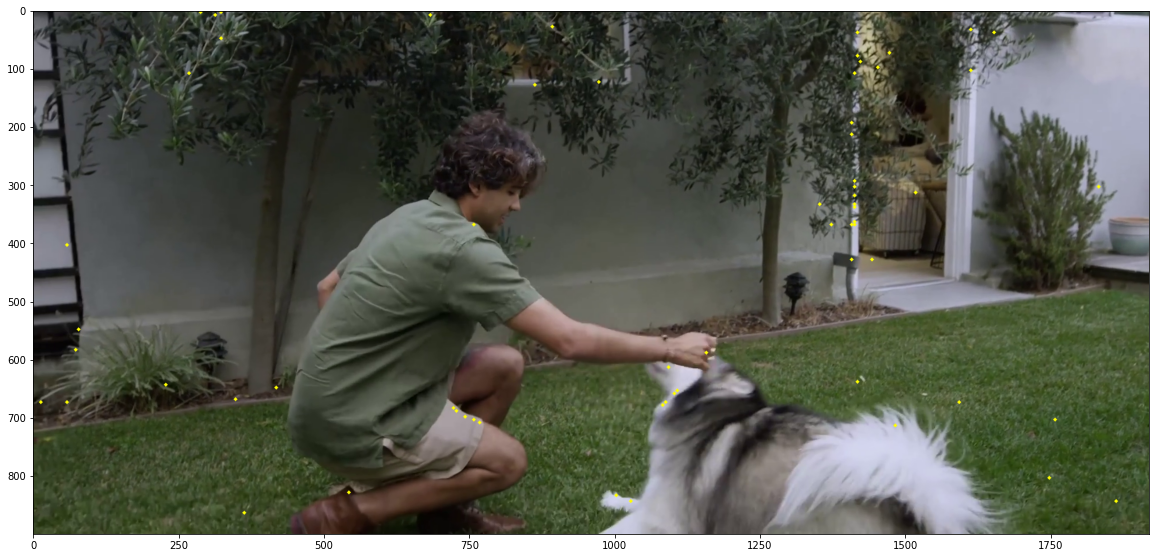

In [6]:
IDX_KP = 0

cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, frame = cap.read()

while ret:
    if START_IDX_KP <= IDX_KP < END_IDX_KP:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints = fast.detect_with_adaptive_threshold_and_grid(
            gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
            percentage=0.15, init_thresholds=None, rows=rows, cols=cols)
    elif IDX_KP >= END_IDX_KP:
        break
    ret, frame = cap.read()
    IDX_KP += 1
    print(f'IDX={IDX_KP}', end='\r')

img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

# convert output to goodFeaturesToTrack shape
keypoints = np.flip(np.expand_dims(keypoints, axis=1).astype(np.float32))
print(f"Number of final keypoints: {keypoints.shape[0]}")

### comparison fast and cv2.goodFeaturesToTrack

In [7]:
nb_keypoints = keypoints.shape[0]
# Create some random colors
color = np.random.randint(0, 255, (nb_keypoints,3))

# test Optical flow opencv

In [8]:
from scipy import signal
def optical_flow(I1g, I2g, current_keypoints, window_size=16, tau=1e-2, resize_fact=0.2):
    
    origin_shape = I1g.shape[0:2]
    
    I1g_resized = cv2.resize(I1g, (int(I1g.shape[1]*resize_fact), int(I1g.shape[0]*resize_fact)), interpolation = cv2.INTER_AREA)
    I2g_resized = cv2.resize(I2g, (int(I2g.shape[1]*resize_fact), int(I2g.shape[0]*resize_fact)), interpolation = cv2.INTER_AREA)
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g_resized = I1g_resized / 255. # normalize pixels
    I2g_resized = I2g_resized / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g_resized, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g_resized, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g_resized, kernel_t, boundary='symm', mode=mode) +\
         signal.convolve2d(I1g_resized, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g_resized.shape)
    v = np.zeros(I1g_resized.shape)
    # within window window_size * window_size
    for i in range(w, I1g_resized.shape[0]-w):
        for j in range(w, I1g_resized.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here

            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
                
    u_resized = cv2.resize(u, origin_shape, interpolation = cv2.INTER_NEAREST)
    v_resized = cv2.resize(v, origin_shape, interpolation = cv2.INTER_NEAREST)
    new_kp = np.zeros(current_keypoints.shape)
    for idx, keypoint in enumerate(current_keypoints):
        keypoint = keypoint.astype(int).reshape((2))
        flow_x = u_resized[keypoint[0], keypoint[1]]
        flow_y = v_resized[keypoint[0], keypoint[1]]
        new_kp[idx] = keypoint - np.array((flow_y, flow_x))
    return new_kp, np.ones((new_kp.shape[0], 1))

In [9]:
cap = cv2.VideoCapture("imgs/person_dog.mp4")
IDX = 0
imgs = []

kp_to_use = keypoints.copy()

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    if IDX % skip != 0:
        IDX += 1
        continue
    if START_IDX <= IDX < END_IDX:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        #p1, st, _ = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, kp_to_use, None, **lk_params)
        p1, st = optical_flow(old_gray, frame_gray, kp_to_use, window_size = 16, tau=1e-2)
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = kp_to_use[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        kp_to_use = good_new.reshape(-1,1,2)
        imgs.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)
    
cap.release()
cv2.destroyAllWindows()